# Praca domowa 2
## Karol Degórski

### Import potrzebnych pakietów

In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu" 

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

### Wczytanie danych CIFAR-10

In [2]:
train_set = torchvision.datasets.CIFAR10(root='data/', download=True, transform=torchvision.transforms.ToTensor())
test_set = torchvision.datasets.CIFAR10(root='data/', train=False, transform=torchvision.transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [3]:
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, num_workers=2, batch_size=128)

Bierzemy 20% zbioru treningowego, tak aby obliczenia zajmowały mniej czasu

In [4]:
sample = torch.randperm(len(train_set))[:10000]

In [5]:
train_dataset = torch.utils.data.Subset(train_set, sample)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=128)

### Przygotowanie architektury sieci ResNet

In [7]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

Parametery grid search - zbadamy najważniejszy parametr czyli learning rate

In [8]:
# put all hyper params into a OrderedDict, easily expandable
from collections  import OrderedDict
params = OrderedDict(
    lr = [.001, 0.01]
)
epochs = 10

In [9]:
# import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_loss_test = 0
    self.epoch_num_correct = 0
    self.epoch_num_correct_test = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.loader_test = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, loader_test):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.loader_test = loader_test
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images.to(DEVICE))

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images.to(DEVICE))

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_loss_test = 0
    self.epoch_num_correct = 0
    self.epoch_num_correct_test = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)
    loss_test = self.epoch_loss_test / len(self.loader_test.dataset)
    accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["loss_test"] = loss_test
    results["accuracy_test"] = accuracy_test
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  def track_loss_test(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss_test += loss.item() * self.loader_test.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  def track_num_correct_test(self, preds, labels):
    self.epoch_num_correct_test += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

***Sieć ResNet18***

In [10]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = ResNet18().to(DEVICE)
    #loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    loader = train_loader
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader, test_loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      for batch in test_loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss_test = F.cross_entropy(preds, labels)
        m.track_loss_test(loss_test)
        m.track_num_correct_test(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')

,run,epoch,loss,accuracy,loss_test,accuracy_test,epoch duration,run duration,lr
0,1,1,1.718599,0.3728,1.525264,0.4457,21.949593,28.534858,0.001
1,1,2,1.371841,0.5068,1.352077,0.5006,22.135052,51.977423,0.001
2,1,3,1.189868,0.5739,1.169259,0.5881,22.169377,76.277319,0.001
3,1,4,1.010531,0.6431,1.054454,0.6325,21.929172,99.427489,0.001
4,1,5,0.857065,0.7006,1.037110,0.6433,21.974745,122.642149,0.001
5,1,6,0.724002,0.7457,1.001370,0.6675,21.932561,145.755765,0.001
6,1,7,0.593740,0.7948,1.044182,0.6620,21.868438,168.852505,0.001
7,1,8,0.421281,0.8549,1.071569,0.6695,21.935953,192.015784,0.001
8,1,9,0.300492,0.8979,1.144127,0.6748,21.903763,215.139222,0.001
9,1,10,0.216892,0.9297,1.239062,0.6643,21.877658,238.202003,0.001


Widzimy, że udało się osiągnąć poziom accuracy 0,66 na zbiorze testowym w 10 epok (na zbiorze trenignowym osiągneliśmy 0,93). Zwiększenie zbioru treningowego pozwoliłoby jeszcze podbić ten wynik

***Sieć ResNet34***

Sprawdziwy, czy większa sieć osiągnie lepsze wyniki

In [11]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = ResNet34().to(DEVICE)
    #loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    loader = train_loader
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader, test_loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      for batch in test_loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss_test = F.cross_entropy(preds, labels)
        m.track_loss_test(loss_test)
        m.track_num_correct_test(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results2')

,run,epoch,loss,accuracy,loss_test,accuracy_test,epoch duration,run duration,lr
0,1,1,1.821656,0.3390,1.588243,0.4278,34.962670,36.424786,0.001
1,1,2,1.483807,0.4679,1.437302,0.4891,35.092723,73.691503,0.001
2,1,3,1.280750,0.5338,1.298642,0.5376,34.935197,110.891486,0.001
3,1,4,1.143525,0.5889,1.148326,0.5951,34.936311,148.119834,0.001
4,1,5,0.991254,0.6465,1.093063,0.6233,35.579450,185.807283,0.001
5,1,6,0.877457,0.6879,1.036930,0.6462,34.920540,222.891027,0.001
6,1,7,0.810586,0.7159,0.984200,0.6612,35.019519,260.182925,0.001
7,1,8,0.704482,0.7496,1.002866,0.6643,34.941170,297.206233,0.001
8,1,9,0.598080,0.7872,0.968181,0.6797,34.970634,334.330398,0.001
9,1,10,0.511642,0.8197,1.008062,0.6778,34.927318,371.430592,0.001


Tym razem również udało się uzyskać accuracy na poziomie 0,67 (0,81 na zbiorze treningowym). Jest to wynik bardzo zbliżony do wyniku sieci ResNet18. Wynika z tego, że zwiękzenie sieci nie zawsze prowadzi do dużo lepszych wyników. Natomiast duża sieć uczy się wolniej. Ponadto większa sieć to większy poziom skomplikowania modelu co utrudnia wyjaśnianie predykcji.

### Zaprezentowanie zjawiska przeuczenia

Dodamy dropout na poziomie 0,1 (jest to mała wartość) do sieci ResNet18 z learning rate równym 0,01

In [26]:
model = ResNet18()

def append_dropout(model, rate=0.1):
        for name, module in model.named_children():
            if len(list(module.children())) > 0:
                append_dropout(module)
            if isinstance(module, nn.BatchNorm2d):
                new = nn.Sequential(module, nn.Dropout2d(p=0.05, inplace=True))
                setattr(model, name, new)


append_dropout(model)

In [27]:
m = RunManager()
params = OrderedDict(
    lr = [0.01]
)
# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = model.to(DEVICE)
    #loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    loader = train_loader
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader, test_loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      for batch in test_loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss_test = F.cross_entropy(preds, labels)
        m.track_loss_test(loss_test)
        m.track_num_correct_test(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results3')

,run,epoch,loss,accuracy,loss_test,accuracy_test,epoch duration,run duration,lr
0,1,1,2.117229,0.2468,1.836592,0.2983,23.712620,26.243484,0.01
1,1,2,1.804332,0.3360,1.724085,0.3446,23.498095,51.056405,0.01
2,1,3,1.669602,0.3846,1.569221,0.4179,23.394082,75.780994,0.01
3,1,4,1.572317,0.4211,1.470461,0.4605,23.457712,100.510108,0.01
4,1,5,1.469992,0.4611,1.434795,0.4787,23.431932,125.246028,0.01
5,1,6,1.400490,0.4971,1.348386,0.5042,23.458246,149.919545,0.01
6,1,7,1.295578,0.5293,1.299048,0.5238,23.446174,174.614107,0.01
7,1,8,1.183450,0.5760,1.214316,0.5634,23.451795,199.331148,0.01
8,1,9,1.072621,0.6180,1.193715,0.5695,23.412645,224.077095,0.01
9,1,10,0.977309,0.6523,1.158053,0.6013,23.428334,248.773215,0.01


Widzimy, że dropout w tym przypadku pozwolił na stabilne zwiększanie accuracy na zbiorze testowym, ale nie przyniósł znaczącej poprawy uczenia. Wynika to z faktu, że trenuje model na tylko 10 epokach. Żeby  lepiej sprawdzić działanie dropout należałoby zwiększyć liczbę epok oraz wykorzystać cały zbiór treningowy

### Zapisanie dotychczasowych rezultatów

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
!cp -av './runs/' '/content/gdrive/My Drive/temp-runs'

'./runs/' -> '/content/gdrive/My Drive/temp-runs'
'./runs/Mar30_17-49-07_61e7c82cbc11-Run(lr=0.001)' -> '/content/gdrive/My Drive/temp-runs/Mar30_17-49-07_61e7c82cbc11-Run(lr=0.001)'
'./runs/Mar30_17-49-07_61e7c82cbc11-Run(lr=0.001)/events.out.tfevents.1648662550.61e7c82cbc11.72.0' -> '/content/gdrive/My Drive/temp-runs/Mar30_17-49-07_61e7c82cbc11-Run(lr=0.001)/events.out.tfevents.1648662550.61e7c82cbc11.72.0'
'./runs/Mar30_17-53-06_61e7c82cbc11-Run(lr=0.01)' -> '/content/gdrive/My Drive/temp-runs/Mar30_17-53-06_61e7c82cbc11-Run(lr=0.01)'
'./runs/Mar30_17-53-06_61e7c82cbc11-Run(lr=0.01)/events.out.tfevents.1648662786.61e7c82cbc11.72.1' -> '/content/gdrive/My Drive/temp-runs/Mar30_17-53-06_61e7c82cbc11-Run(lr=0.01)/events.out.tfevents.1648662786.61e7c82cbc11.72.1'
'./runs/Mar30_17-57-02_61e7c82cbc11-Run(lr=0.001)' -> '/content/gdrive/My Drive/temp-runs/Mar30_17-57-02_61e7c82cbc11-Run(lr=0.001)'
'./runs/Mar30_17-57-02_61e7c82cbc11-Run(lr=0.001)/events.out.tfevents.1648663022.61e7c82cbc11

### Macierz konfuzji

Do zaprezentowania macierzy konfuzji użyję modelu ResNet18 z learning rate na poziomie 0,001. Dzięki temu osiągnę przyzwoity poziom accuracy w akceptowalnym czasie

In [16]:
model = ResNet18()
m = RunManager()
params = OrderedDict(
    lr = [0.001]
)
# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = model.to(DEVICE)
    #loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    loader = train_loader
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader, test_loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      for batch in test_loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss_test = F.cross_entropy(preds, labels)
        m.track_loss_test(loss_test)
        m.track_num_correct_test(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results4')

,run,epoch,loss,accuracy,loss_test,accuracy_test,epoch duration,run duration,lr
0,1,1,1.723829,0.3687,1.487528,0.4488,22.097314,23.192158,0.001
1,1,2,1.379429,0.4975,1.284909,0.5411,22.112216,46.585160,0.001
2,1,3,1.182351,0.5680,1.198821,0.5712,22.032570,69.817081,0.001
3,1,4,0.990513,0.6460,1.076860,0.6215,22.114675,93.144830,0.001
4,1,5,0.862491,0.6957,1.042355,0.6390,22.113611,116.504315,0.001
5,1,6,0.697398,0.7547,1.009609,0.6542,22.099994,139.923295,0.001
6,1,7,0.560907,0.8016,1.045514,0.6601,22.115069,163.270490,0.001
7,1,8,0.436573,0.8491,1.090227,0.6611,22.109454,186.630256,0.001
8,1,9,0.327668,0.8866,1.155713,0.6648,22.068459,209.903912,0.001
9,1,10,0.205600,0.9342,1.253970,0.6630,22.034274,233.139668,0.001


Model osiągnął poziom accuracy 0,66 na zbiorze testowym

Narysujemy teraz macierz konfuzji

In [17]:
PATH = "model.pt"

# Save
torch.save(network.state_dict(), PATH)

# Load
device = torch.device('cpu')
model = ResNet18()
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [18]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds

test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1000,num_workers=2)
test_preds = get_all_preds(model, test_loader)
actual_labels = torch.Tensor(test_set.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 6676
accuracy: 0.6676


Confusion matrix, without normalization
[[686  16 114  23  33  13   8  13  51  43]
 [ 38 826   2  13   8   1   3   8  30  71]
 [ 57   7 613  63  91  63  63  23  14   6]
 [ 19  12 115 385  72 262  77  29  21   8]
 [ 22   2 108  54 637  48  68  49  11   1]
 [ 17   5  97 109  54 629  35  44   5   5]
 [  5   2  66  61  47  31 765  12   5   6]
 [ 30   1  60  32 126  98   9 629   7   8]
 [146  20  19  10  15  13   3   9 731  34]
 [ 36  81   3  24   8  16   3  28  26 775]]


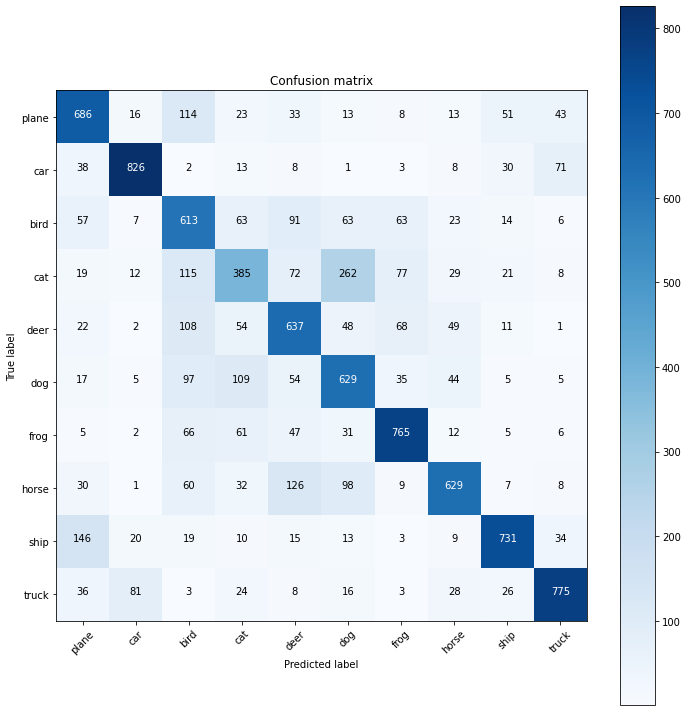

In [19]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(test_set.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)

Zauważmy, że najczęściej sieć myliła psy z kotami tj. model zaklasyfikował bardzo dużo psów jako koty. Nie jest to bardzo dziwne, ponieważ są to dosyć zbliżone w kształcie i rozmiarze zwierzęta domowe. Ponadto model też mylił często ptaki z samolotami i psy z końmi. Wydają się to całkiem naturalne pomyłki ze względu na zbliżone kształty tych rzeczy. Dziwne może być mylenie samolotów ze statkami - nie są to jakoś bardzo zbliżone kształtem obiekty, ale rozmiarowo są podobne.

Zobaczmy przykładowe psy, które dla modelu są kotami:

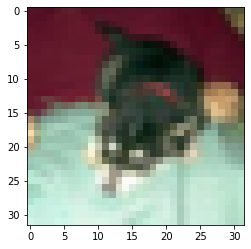

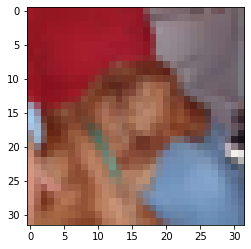

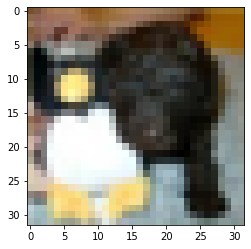

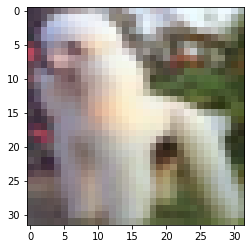

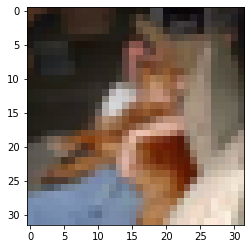

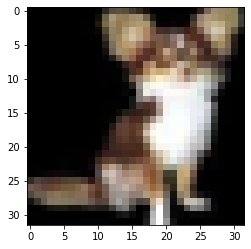

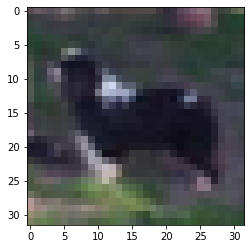

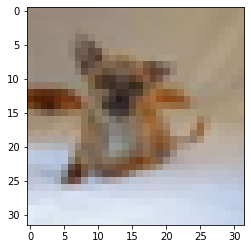

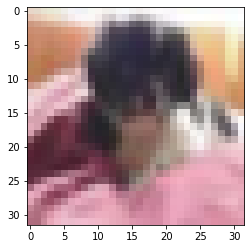

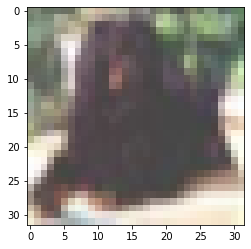

In [20]:
error_inx = []
for i in range(len(actual_labels)):
  if actual_labels[i] == torch.tensor(5) and test_preds.argmax(dim=1)[i] == torch.tensor(3):
    error_inx.append(i)

for i in range(10):
  image, label = test_set[error_inx[i]]
  plt.imshow(image.cpu().permute(1, 2, 0))
  plt.show()

Istotnie można przyznać, że jest to trudne zadanie do zaklasyfikowania

### t-SNE

Na koniec zwizualizujemy nasz zbiór danych wykorzystując t-SNE na tym samym modelu co macierz konfuzji

In [21]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds

test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1000,num_workers=2)
test_preds = get_all_preds(model, test_loader)


In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(test_preds)
pca_features = pca.transform(test_preds)

from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(pca_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [23]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

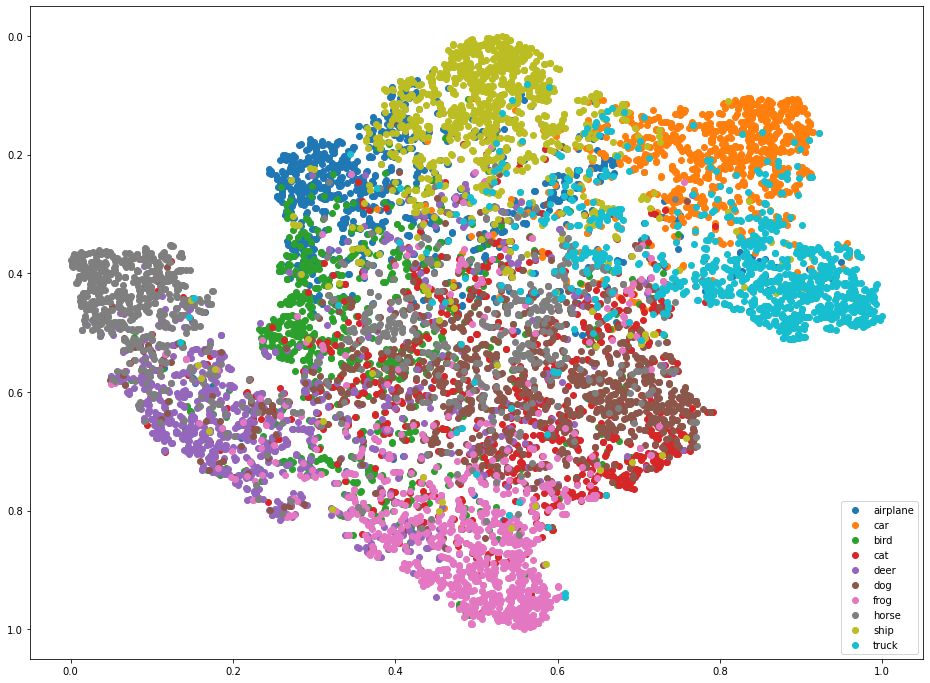

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,12))

classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_test = np.array([i[1] for i in test_set])
for i in range(len(classes)):
    y_i = y_test == i
    plt.scatter(tx[y_i[:]], ty[y_i[:]], label=classes[i])
plt.legend(loc=4)
plt.gca().invert_yaxis()
plt.show()

Widzimy, że wnioski z analizy macierzy konfuzji potwierdzają się na wizualizacji t-SNE. Kropki związane z psami i kotami nie wyodrębniają dwóch odzielnych klastrów. Samoloty istotnie są blisko ptaków i statków. Z kolei konie wydzielają odrębny klaster, ale część z nich jest wśród psów. Najbardziej wyodrębnione są żaby, samochody i ciężarówki co również potwierdza się w największej liczbie prawidłowo zaklasyfikowanych obserwacji

### Wnioski

- trenowanie sieci neuronowej typu ResNet służącej do klasyfikacji obrazów trwa dużo czasu
- wykorzystanie gpu skraca obliczenia
- znalezienie odpowiedniej wartości learning rate może okazać się kluczowe do osiągnięcia przez model wysokich wyników
- żeby zwiększyć poziom accuracy wystarczy wziąć cały zbiór treningowy (ze względów czasowych wziąłem 20%)
- model myli się w klasach które intuicyjnie wydają się trudne do klasyfikacji
- nie zawsze zwiększenie architektury sieci prowadzi do znaczącej poprawy wyników, natomiast wydłuża czas uczenia. Czasami lepiej wybrać prostszy model
- wykorzystanie t-SNE pozwala zapoznać się ze strukturą zbioru danych